# Conditional Logic Demonstration Notebook

## Aims of Notebook

- Read accumulated I and Q data from a readout buffer and conditionally trigger a different pulse if I exceeds some threshold.

## To Do

- Remove AveragerProgram
- See if time between readout and second pulse may be reduced

In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3594]:
# Board libraries
from qick import *
import Pyro4

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99" # <-- SET IP ADDRESS
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)


QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by o

In [3591]:
class ConditionalPulse(AveragerProgram):
    def __init__(self,soccfg,cfg):
        super().__init__(soccfg,cfg)

    def initialize(self):
        freq_mhz = 200
        freq = self.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)

        length = 0.05

        for ch in range(2):
            self.declare_gen(ch=ch, nqz=1)
  
        gen_length = self.us2cycles(length, gen_ch=1)
        phase_deg = 276.65
        phase = prog.deg2reg(phase_deg, gen_ch=0)
        for ch in range(2):
            self.set_pulse_registers(ch=ch, freq=freq, style="const", phase=phase, 
                                 gain=20000, length=gen_length)


        ro_phase = self.deg2reg(262.04402341090645, ro_ch=1, gen_ch=None)
        # print(ro_phase)
        ro_length = self.us2cycles(length-0.001, ro_ch=1)
        self.declare_readout(ch=1, freq=freq_mhz, length=180, phase=ro_phase ,gen_ch=1)

        # self.synci(100) 
    
    def body(self):
        self.pulse(ch=1, t=0) 
        self.pulse(ch=0, t=0) 
        self.trigger(adcs=[1], pins=[0], adc_trig_offset=0) 
        # self.trigger(adcs=[1]) 
        print("Timestamps")
        print(self.get_max_timestamp(gens=False, ros=True))
        print(self.get_max_timestamp(gens=True, ros=False))
        self.pulse(ch=0, t=self.get_max_timestamp(gens=False, ros=True))
        
        self.wait_all(80) #pause execution of commands until the end of the readout window, plus N cycles
        self.sync_all()
        self.trigger(pins=[0])
        self.pulse(ch=0)
        # self.sync_all() #increment the time of subsequent pulse and trigger commands to the end of the last pulse, plus 500

        self.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
        # self.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
        self.memwi(0, 1, 123)
        # self.memwi(0, 2, 124)
        
        # self.condj(0, 1, '<', 0, "JUMP_LOC")
        # self.pulse(ch=0)
        # self.label("JUMP_LOC")

        # the extra time in wait_all needs to be at least ~30, otherwise you will read a stale value corresponding to the previous readout
        # try a smaller value and you will see what I mean
        # the extra time here is optional? do whatever you need to get the timeline you want
        # if you are only running one rep and there are no more triggers or pulses, you don't even need a sync

        # it's important to only use registers that are not used elsewhere
        # some registers are used for averagerprogram/raveragerprogram counters, and each generator uses some registers for pulse parameters
        # we don't currently have a nice way to check which registers are unused (this is issue #19)
        # for now: page 0 registers 1-12 are not used

Timestamps
133.33333333333331
20.666666666666668
I and Q values read from tproc input: [-4299, 1486]
sum of I and Q in decimated buffer: [-4299.0, 20981.0]
102.45574670334732

// Program

        regwi 0, $22, 87381333;                 //freq = 87381333
        regwi 0, $23, 825140765;                //phase = 3300563062
        bitwi 0, $23, $23 << 2;
        mathi 0, $23, $23 + 2;
        regwi 0, $25, 20000;                    //gain = 20000
        regwi 0, $26, 589855;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 31 
        regwi 1, $22, 87381333;                 //freq = 87381333
        regwi 1, $23, 825140765;                //phase = 3300563062
        bitwi 1, $23, $23 << 2;
        mathi 1, $23, $23 + 2;
        regwi 1, $25, 20000;                    //gain = 20000
        regwi 1, $26, 589855;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 31 
        regwi 0, $15, 0;
        regwi 0, $14, 0;
LOOP_J: regwi 1, $27, 0;

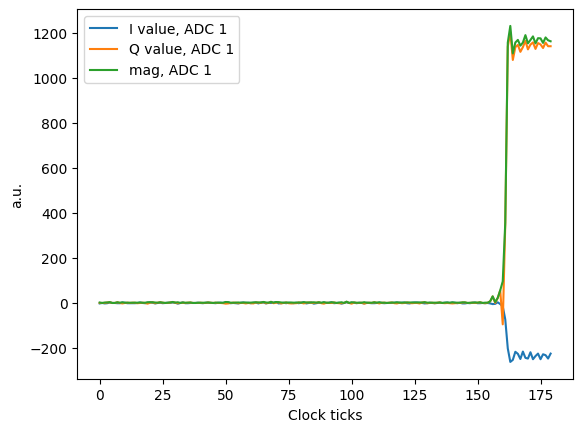

In [3607]:
config={"reps":1,
        # "soft_avgs":10,
        }

prog =ConditionalPulse(soccfg, config)
# soc.reset_gens() # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)

results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in range(123,125)]
print("I and Q values read from tproc input:", results)
print("sum of I and Q in decimated buffer:", [sum(iq) for iq in iq_list[0]])
i = np.average(iq[0])
q = np.average(iq[1])
print(np.angle(i+1j*q, deg=True)%360)

# Plot results.
plt.figure(1)
iq = iq_list[0]
plt.plot(iq[0], label="I value, ADC %d"%(1))
plt.plot(iq[1], label="Q value, ADC %d"%(1))
plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(1))

# print(sum(iq[0]), sum(iq[1]))

plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.legend();
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

print(prog)

In [3495]:
prog.cycles2us(220) # Number of cycles between ro beginning and non-junk data
prog.cycles2us(133)
prog.cycles2us(125, ro_ch=1)

0.22605613425925924

```
waiti 0, 35;
```
```
regwi 0, $16, 32768;                    //out = 0b1000000000000000
seti 7, 0, $16, 169;                    //ch =0 out = $16 @t = 0
seti 7, 0, $0, 179;                     //ch =0 out = 0 @t = 0
waiti 0, 224;
```

In [2887]:
print(prog.cycles2us(169))
print(prog.cycles2us(179))
print(prog.cycles2us(224))
print(prog.cycles2us(169-78))

0.41259765625
0.43701171875
0.546875
0.22216796875


In [3232]:
class ConditionalPulse(AveragerProgram):
    def __init__(self,soccfg,cfg):
        super().__init__(soccfg,cfg)

    def initialize(self):
        freq_mhz = 200
        freq = self.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)

        length = 0.05
        gen_length = self.us2cycles(length, gen_ch=1)
        ro_length = self.us2cycles(length-0.001, ro_ch=1)

        # for ch in range(1):
        #     self.declare_gen(ch=ch, nqz=1)
  
        # for ch in range(1):
        #     self.set_pulse_registers(ch=ch, freq=freq, style="const", phase=0, 
        #                          gain=20000, length=gen_length)


        self.declare_readout(ch=1, freq=freq_mhz, length=ro_length,gen_ch=1)

        self.synci(200) 
    
    def body(self):
        # self.pulse(ch=1, t=100) 
        # self.pulse(ch=0, t=0) 
        # self.trigger(pins=[0], t=35, width=self.us2cycles(0.05))
        self.trigger(adcs=[1], t=0, adc_trig_offset=132) 
        
        # self.wait_all(35) #pause execution of commands until the end of the readout window, plus N cycles
        # self.trigger(pins=[0])
        # self.pulse(ch=0)
        # self.sync_all() #increment the time of subsequent pulse and trigger commands to the end of the last pulse, plus 500

        # self.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
        # self.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
        # self.memwi(0, 1, 123)
        # self.memwi(0, 2, 124)
        
        # self.condj(0, 1, '<', 0, "JUMP_LOC")
        # self.label("JUMP_LOC")

config={"reps":1}
prog =ConditionalPulse(soccfg, config)
print(prog)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)


// Program

        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 0;
LOOP_J: regwi 0, $16, 32768;                    //out = 0b1000000000000000
        seti 7, 0, $16, 140;                    //ch =0 out = $16 @t = 0
        seti 7, 0, $0, 150;                     //ch =0 out = 0 @t = 0
        mathi 0, $15, $15 + 1;
        memwi 0, $15, 1;
        loopnz 0, $14, @LOOP_J;
        end ;


read = 2 cycles
memwi = 2 cycles
condj = 4 cycles

wait_all = 124.8 ns

// Program

LOOP_J: regwi 0, $16, 32768;                    //out = 0b1000000000000000
        seti 7, 0, $16, 132;                    //ch =0 out = $16 @t = 0
        seti 7, 0, $0, 142;                     //ch =0 out = 0 @t = 0

In [3208]:
print(prog.cycles2us(1)*1e3*35)

85.44921875


In [2375]:
iq_list = prog.acquire(soc, load_pulses=True, progress=True)

results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in range(123,125)]
print("I and Q values read from tproc input:", results)
print("I and Q values in accumulated buffer:", [iq*config['readout_length'] for iq in iq_list])


  0%|          | 0/1 [00:00<?, ?it/s]

I and Q values read from tproc input: [-14, 0]


KeyError: 'readout_length'

## BELOW CELL DOES NOT WORK

In [ ]:
prog = QickProgram(soccfg) # Create program object

prog.declare_gen(ch=1, nqz=1)
prog.set_pulse_registers(ch=1, gain=10000, freq=prog.freq2reg(100), phase=0, style="const", length=500)
prog.declare_readout(ch=1,length=100,freq=100,gen_ch=1)
# prog.pulse(ch=1, t=0)
prog.regwi(0,3,1)
prog.trigger(adcs=[1], t=400, adc_trig_offset=0, rp=0, r_out=3)
prog.waiti(0,1000)

# prog.read(1,0,"lower",3)
prog.regwi(0,2,1)
# prog.condj(0,2,'>',3,'after_reset')
prog.trigger(pins=[0], t=0, width=10)

prog.memwi(0, 3, 123)
# prog.label('after_reset')
prog.wait_all()
prog.end()

prog.config_all(soc) # Load assembly to board
soc.tproc.start() # Run program

time.sleep(0.1)

data = soc.tproc.single_read(addr=123)
print(data)

# print(prog)

32768


In [3562]:
prog = QickProgram(soccfg)
freq_mhz = 200
freq = prog.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)
length = 0.05
gain=10000

for ch in range(2):
    prog.declare_gen(ch=ch, nqz=1)

gen_length = prog.us2cycles(length, gen_ch=1)
for ch in range(2):
    prog.set_pulse_registers(ch=ch, freq=freq, style="const", phase=0, 
                            gain=gain, length=gen_length)

ro_length = prog.us2cycles(length, ro_ch=1)
prog.declare_readout(ch=1, freq=freq_mhz, length=ro_length, gen_ch=1)

prog.synci(100) 
    
prog.trigger(adcs=[1], adc_trig_offset=132) 
prog.pulse(ch=1) 
prog.pulse(ch=0) 

prog.wait_all(35) #pause execution of commands until the end of the readout window, plus N cycles
# self.waiti(1000, 0)
# self.sync_all() #increment the time of subsequent pulse and trigger commands to the end of the last pulse, plus 500

prog.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
prog.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
prog.memwi(0, 1, 123)
prog.memwi(0, 2, 124)

# prog.regwi(0, 1, 5000)

prog.condj(0, 1, '>', 0, "JUMP_LOC")
prog.pulse(ch=0)
prog.label("JUMP_LOC")
prog.end()

prog.config_all(soc) # Load the assembly onto the board

# prog.compile()
# soc.start_src("external")
# prog.load_pulses(soc)
# prog.config_gens(soc)
# prog.config_readouts(soc)
# soc.load_bin_program(prog.binprog)

soc.tproc.start() # Start tproc program execution

results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in range(123,125)]
print("I and Q values read from tproc input:", results)

I and Q values read from tproc input: [-362, -2920]
